In [38]:
import os
import re
import random
import string

dataset_folder_name = "asl_dataset"
dataset_directory = os.path.join(os.getcwd(), "AlphabetDataset", dataset_folder_name)
def generate_random_filename(existing_filenames, extension):
    """Generate a unique random filename."""
    while True:
        random_name = ''.join(random.choices(string.ascii_letters + string.digits, k=8)) + extension
        if random_name not in existing_filenames:
            return random_name

def rename_images_in_folders(dataset_path):
    # Iterate through each folder inside the dataset
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        
        # Check if it is a directory and not a hidden/system folder
        if not os.path.isdir(folder_path) or folder.startswith("."):
            continue
        
        # List all files
        files = sorted(os.listdir(folder_path))
        existing_filenames = set()
        
        # First rename all files to random names
        temp_filenames = {}
        for file in files:
            old_file_path = os.path.join(folder_path, file)
            
            # Skip directories
            if not os.path.isfile(old_file_path):
                continue
            
            # Get file extension
            file_extension = os.path.splitext(file)[1] or ".jpeg"
            
            # Generate unique random name
            random_name = generate_random_filename(existing_filenames, file_extension)
            new_temp_path = os.path.join(folder_path, random_name)
            
            os.rename(old_file_path, new_temp_path)
            existing_filenames.add(random_name)
            temp_filenames[random_name] = file  # Keep track of renamed files
        
        # Now rename files to the correct format, starting from 1 without checking past collisions
        next_number = 1
        for temp_file in sorted(temp_filenames.keys()):
            temp_file_path = os.path.join(folder_path, temp_file)
            
            new_file_name = f"_{folder}_{next_number}.jpeg"
            new_file_path = os.path.join(folder_path, new_file_name)
            os.rename(temp_file_path, new_file_path)
            print(f"Renamed {temp_file} -> {new_file_name}")
            
            next_number += 1  # Increment for next file
        
        print(f"Renaming completed for folder: {folder}")

# Automatically detect dataset directory path based on current working directory

rename_images_in_folders(dataset_directory)

print("Renaming complete!")


Renamed 06eVSfdE.jpeg -> _a_1.jpeg
Renamed 0AxHhM87.jpeg -> _a_2.jpeg
Renamed 0MZvAsRe.jpeg -> _a_3.jpeg
Renamed 1Akoq4uR.jpeg -> _a_4.jpeg
Renamed 1Kn6Mwfh.jpeg -> _a_5.jpeg
Renamed 1OFVW1pa.jpeg -> _a_6.jpeg
Renamed 1RfQKBrN.jpeg -> _a_7.jpeg
Renamed 1deAzHGE.jpeg -> _a_8.jpeg
Renamed 1lpRSzJB.jpeg -> _a_9.jpeg
Renamed 1zHqBLYw.jpeg -> _a_10.jpeg
Renamed 20RuoKxd.jpeg -> _a_11.jpeg
Renamed 29gLLsr8.jpeg -> _a_12.jpeg
Renamed 2FjAm1Ub.jpeg -> _a_13.jpeg
Renamed 2W1UyVgx.jpeg -> _a_14.jpeg
Renamed 2ZFH2y2S.jpeg -> _a_15.jpeg
Renamed 2aZqVJWE.jpeg -> _a_16.jpeg
Renamed 2f1bTnRg.jpeg -> _a_17.jpeg
Renamed 3FhYRWac.jpeg -> _a_18.jpeg
Renamed 3RBoEcvN.jpeg -> _a_19.jpeg
Renamed 3mHzrFSW.jpeg -> _a_20.jpeg
Renamed 3tBgu0kw.jpeg -> _a_21.jpeg
Renamed 4FmxPoFG.jpeg -> _a_22.jpeg
Renamed 4whVg9My.jpeg -> _a_23.jpeg
Renamed 5FJYIcSp.jpeg -> _a_24.jpeg
Renamed 5WlSNlSF.jpeg -> _a_25.jpeg
Renamed 5niETr8X.jpeg -> _a_26.jpeg
Renamed 5r9yZ8OG.jpeg -> _a_27.jpeg
Renamed 61IdkiYx.jpeg -> _a_28.jpeg
R

In [39]:
import cv2
import mediapipe as mp
import numpy as np
import os
import joblib
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Paths
DATASET_PATH = dataset_directory

# Verify if the dataset path exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset path not found: {DATASET_PATH}")

LABELS = sorted([folder for folder in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, folder))])

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# Function to extract label from filename
def extract_label_from_filename(filename):
    match = re.search(r'_([a-z0-9])_', filename)
    return match.group(1) if match else None

# Function to extract hand landmarks
def extract_landmarks(image_path):
    if not os.path.isfile(image_path):
        return None  # Ensure we only process files
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to load image {image_path}")
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    if results.multi_hand_landmarks:
        landmarks = []
        for hand_landmarks in results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])

        # Extract relative path
        relative_path = os.path.relpath(image_path, DATASET_PATH)
        print(f"Successfully extracted landmarks from: {relative_path}")  # Debugging output
        return landmarks
    return None

# Prepare dataset
X, y = [], []
Label_List = []
Label_Count = []
Label_FailCount = []
for label in LABELS:
    Label_List.append(label)
    label_path = os.path.join(DATASET_PATH, label)
    if os.path.isdir(label_path):
        failCount = 0
        count = 0
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            if not os.path.isfile(img_path):
                continue  # Skip directories
            extracted_label = extract_label_from_filename(img_file)
            if extracted_label:
                landmarks = extract_landmarks(img_path)
                if landmarks:
                    X.append(landmarks)
                    y.append(extracted_label)
                    count = count + 1
                    # Extract relative path
                    relative_path = os.path.relpath(img_path, DATASET_PATH)
                    print(f"File used for training: {relative_path} - Label: {extracted_label}")  # Debugging output
                else:
                    failCount = failCount + 1
        Label_Count.append(count)
        Label_FailCount.append(failCount)


Successfully extracted landmarks from: a\_a_1.jpeg
File used for training: a\_a_1.jpeg - Label: a
Successfully extracted landmarks from: a\_a_10.jpeg
File used for training: a\_a_10.jpeg - Label: a
Successfully extracted landmarks from: a\_a_100.jpeg
File used for training: a\_a_100.jpeg - Label: a
Successfully extracted landmarks from: a\_a_102.jpeg
File used for training: a\_a_102.jpeg - Label: a
Successfully extracted landmarks from: a\_a_103.jpeg
File used for training: a\_a_103.jpeg - Label: a
Successfully extracted landmarks from: a\_a_104.jpeg
File used for training: a\_a_104.jpeg - Label: a
Successfully extracted landmarks from: a\_a_105.jpeg
File used for training: a\_a_105.jpeg - Label: a
Successfully extracted landmarks from: a\_a_106.jpeg
File used for training: a\_a_106.jpeg - Label: a
Successfully extracted landmarks from: a\_a_107.jpeg
File used for training: a\_a_107.jpeg - Label: a
Successfully extracted landmarks from: a\_a_108.jpeg
File used for training: a\_a_108.jp

In [40]:
totalTrainedSuccess = 0
for i in range(0, len(Label_Count)):
    totalTrainedSuccess = totalTrainedSuccess + Label_Count[i]
print("Total Photo Sucessfully Trained:", totalTrainedSuccess)
for i in range(0, len(Label_Count)):
    print(f"Label{Label_List[i]}:  LandMarkSuccess = {Label_Count[i]}, LandMarkFail = {Label_FailCount[i]}")

Total Photo Sucessfully Trained: 6933
Labela:  LandMarkSuccess = 274, LandMarkFail = 62
Labelb:  LandMarkSuccess = 247, LandMarkFail = 17
Labelc:  LandMarkSuccess = 311, LandMarkFail = 73
Labeld:  LandMarkSuccess = 240, LandMarkFail = 39
Labele:  LandMarkSuccess = 303, LandMarkFail = 84
Labelf:  LandMarkSuccess = 309, LandMarkFail = 15
Labelg:  LandMarkSuccess = 224, LandMarkFail = 34
Labelh:  LandMarkSuccess = 400, LandMarkFail = 2
Labeli:  LandMarkSuccess = 318, LandMarkFail = 30
Labelj:  LandMarkSuccess = 284, LandMarkFail = 70
Labelk:  LandMarkSuccess = 324, LandMarkFail = 9
Labell:  LandMarkSuccess = 221, LandMarkFail = 13
Labelm:  LandMarkSuccess = 220, LandMarkFail = 131
Labeln:  LandMarkSuccess = 111, LandMarkFail = 69
Labelo:  LandMarkSuccess = 288, LandMarkFail = 66
Labelp:  LandMarkSuccess = 315, LandMarkFail = 60
Labelq:  LandMarkSuccess = 229, LandMarkFail = 77
Labelr:  LandMarkSuccess = 308, LandMarkFail = 28
Labels:  LandMarkSuccess = 430, LandMarkFail = 71
Labelt:  Land

In [41]:
# Combine Label_List, Label_Count, and Label_FailCount
sorted_labels = sorted(zip(Label_Count, Label_List, Label_FailCount))

# Print the sorted labels
for success, label, fail in sorted_labels:
    print(f"Label {label}: LandMarkSuccess = {success}, LandMarkFail = {fail}")


Label t: LandMarkSuccess = 89, LandMarkFail = 68
Label n: LandMarkSuccess = 111, LandMarkFail = 69
Label z: LandMarkSuccess = 166, LandMarkFail = 20
Label x: LandMarkSuccess = 216, LandMarkFail = 117
Label m: LandMarkSuccess = 220, LandMarkFail = 131
Label l: LandMarkSuccess = 221, LandMarkFail = 13
Label g: LandMarkSuccess = 224, LandMarkFail = 34
Label q: LandMarkSuccess = 229, LandMarkFail = 77
Label u: LandMarkSuccess = 239, LandMarkFail = 43
Label d: LandMarkSuccess = 240, LandMarkFail = 39
Label b: LandMarkSuccess = 247, LandMarkFail = 17
Label y: LandMarkSuccess = 258, LandMarkFail = 42
Label a: LandMarkSuccess = 274, LandMarkFail = 62
Label j: LandMarkSuccess = 284, LandMarkFail = 70
Label o: LandMarkSuccess = 288, LandMarkFail = 66
Label v: LandMarkSuccess = 297, LandMarkFail = 45
Label e: LandMarkSuccess = 303, LandMarkFail = 84
Label r: LandMarkSuccess = 308, LandMarkFail = 28
Label f: LandMarkSuccess = 309, LandMarkFail = 15
Label c: LandMarkSuccess = 311, LandMarkFail = 73

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Ensure dataset is not empty
if len(X) == 0 or len(y) == 0:
    raise ValueError("No valid hand landmarks found in dataset. Check dataset structure.")

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Save the trained model
joblib.dump(clf, 'asl_rf_model.pkl')
print("Model saved as asl_rf_model.pkl")

# Evaluate Model
y_pred = clf.predict(X_test)



# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'macro' for balanced classes
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')



Model saved as asl_rf_model.pkl
Accuracy: 0.9510
Precision: 0.9519
Recall: 0.9510
F1-score: 0.9507


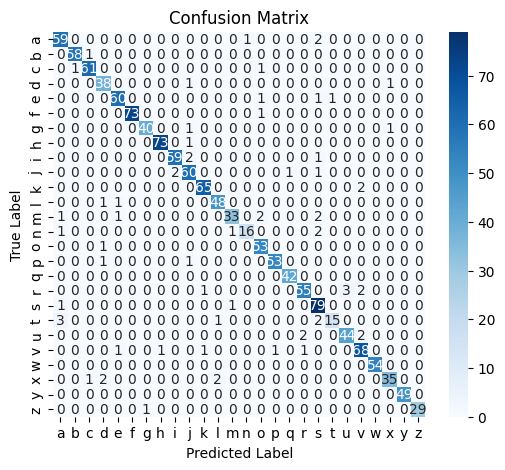

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Label')   
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


✅ Model file found. Loading...


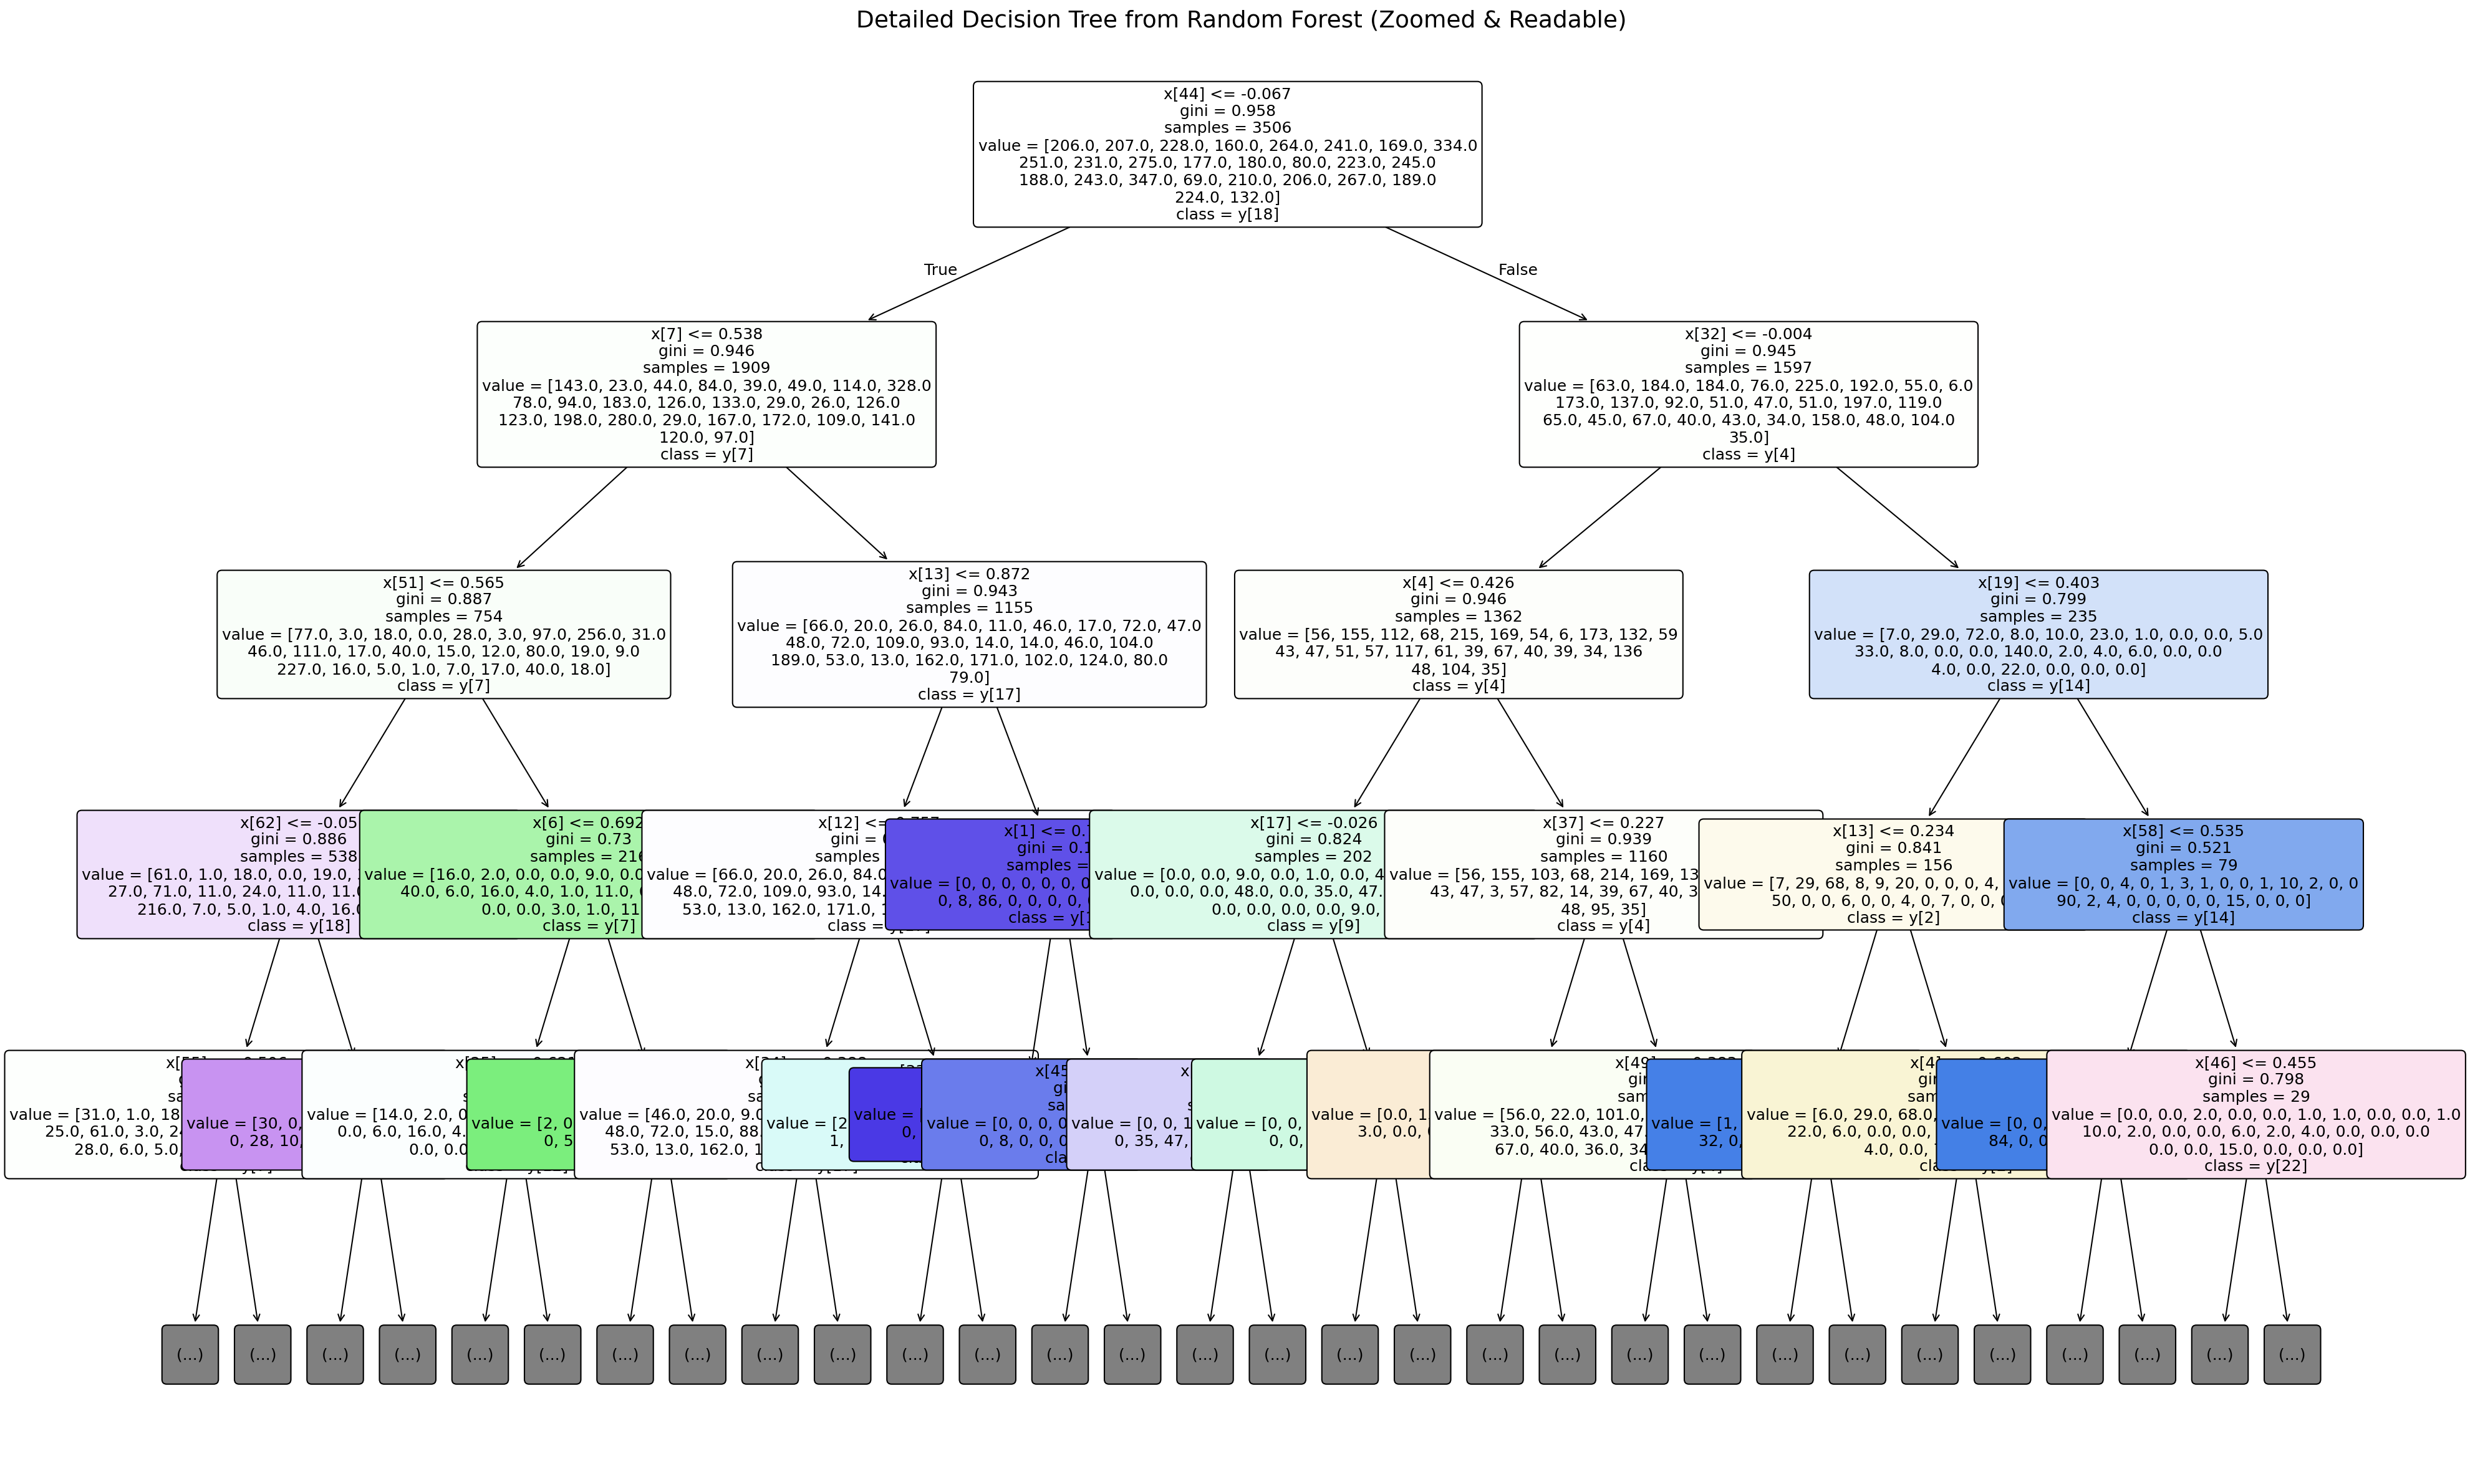

In [44]:
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Define model path
model_path = os.path.join(os.getcwd(), "asl_rf_model.pkl")
# Check if model exists
if os.path.exists(model_path):
    print("✅ Model file found. Loading...")
else:
    print("❌ Model file NOT found. Check the file path!")
    exit()

# Load the trained Random Forest model
clf = joblib.load(model_path)

# Select a single decision tree from the Random Forest
tree = clf.estimators_[0]  # First tree in the forest

# Generate a large and detailed decision tree visualization
plt.figure(figsize=(30, 20), dpi=150)  # Increased figure size

plot_tree(
    tree, 
    filled=True, 
    feature_names=None,  # Replace with actual feature names if available
    class_names=True, 
    rounded=True, 
    fontsize=12,  # Larger font size for readability
    max_depth=4  # Limit depth to keep it readable (adjustable)
)

plt.title("Detailed Decision Tree from Random Forest (Zoomed & Readable)", fontsize=18)
plt.show()


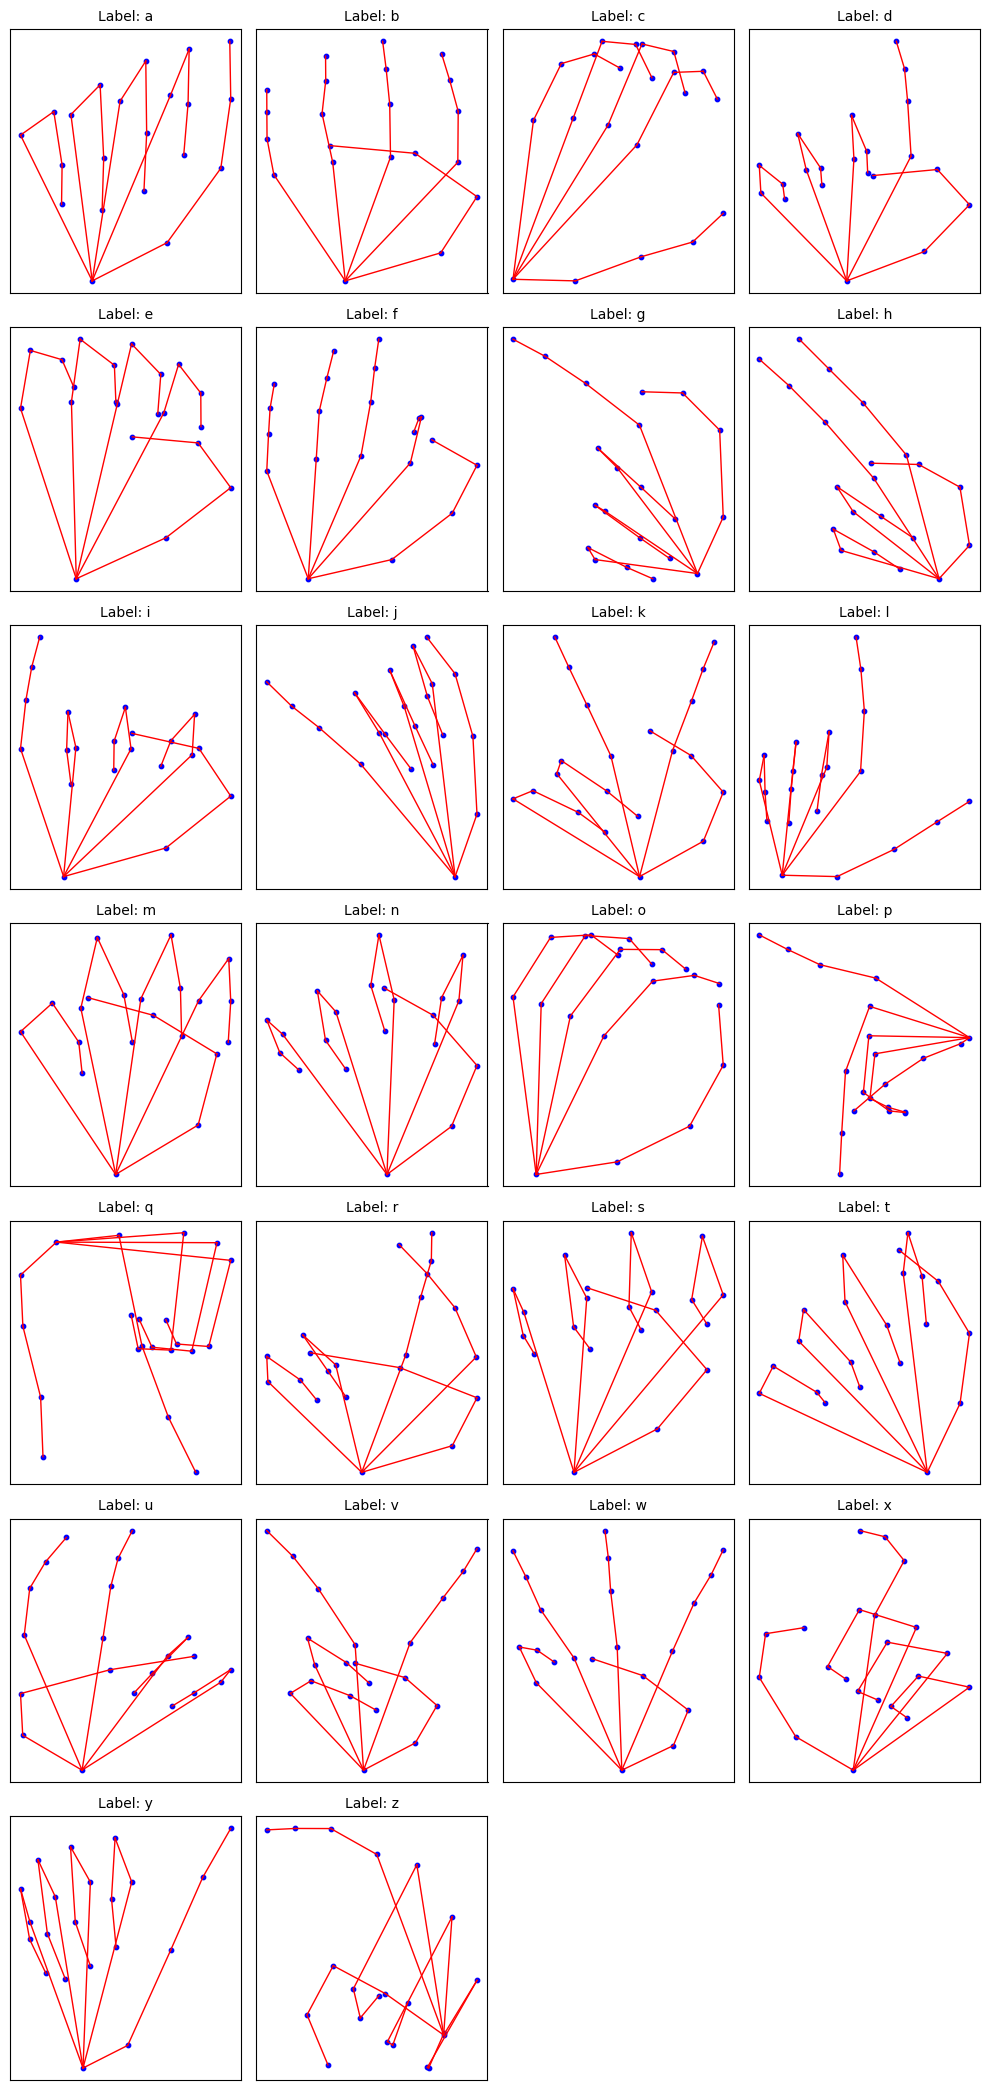

In [45]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Function to extract and store landmarks as numerical values

def extract_landmark_values(landmarks, label):
    if landmarks is None:
        return None
    
    landmarks = np.array(landmarks).reshape(-1, 3)  # Convert to (21,3) format
    
    # Store landmarks as a list of dictionaries
    landmark_data = {
        "label": label,
        "landmarks": [{"x": lm[0], "y": lm[1], "z": lm[2]} for lm in landmarks],
        "connections": [(0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
                        (0, 5), (5, 6), (6, 7), (7, 8),  # Index
                        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
                        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
                        (0, 17), (17, 18), (18, 19), (19, 20)]  # Pinky
    }
    
    return landmark_data

# Function to visualize landmarks
def plot_landmarks(ax, landmarks, label):
    if landmarks is None:
        ax.set_title(f"No landmarks for {label}")
        ax.axis("off")
        return
    
    landmarks = np.array(landmarks).reshape(-1, 3)  # Convert to (21,3) format
    
    ax.scatter(landmarks[:, 0], -landmarks[:, 1], c='blue', s=10)  # Smaller points
    
    # Define connections based on MediaPipe hand structure
    connections = [(0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
                   (0, 5), (5, 6), (6, 7), (7, 8),  # Index
                   (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
                   (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
                   (0, 17), (17, 18), (18, 19), (19, 20)]  # Pinky

    for start, end in connections:
        ax.plot([landmarks[start, 0], landmarks[end, 0]],
                 [-landmarks[start, 1], -landmarks[end, 1]], 'r-', linewidth=1)

    ax.set_title(f"Label: {label}", fontsize=10)
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_yticks([])  # Remove y-axis labels

# Store landmark data for each label
landmark_data_list = []

unique_labels = sorted(set(y))  # Extract unique labels from dataset

num_labels = len(unique_labels)
num_cols = 4  # 4 plots per row
num_rows = max(1, (num_labels + num_cols - 1) // num_cols)  # Ensure at least 1 row

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))
axes = axes.flatten()

for i, label in enumerate(unique_labels):
    idxs = np.where(y == label)[0]
    if len(idxs) == 0:
        continue  # Skip if no landmarks for this label
    idx = idxs[0]  # Get first occurrence of label
    
    # Extract numerical values
    landmark_values = extract_landmark_values(X[idx], label)
    if landmark_values:
        landmark_data_list.append(landmark_values)
    
    # Plot visualization
    plot_landmarks(axes[i], X[idx], label)

# Hide empty subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()





In [46]:
# Save landmarks as JSON file
with open('hand_landmarks_data.json', 'w') as json_file:
    json.dump(landmark_data_list, json_file, indent=4)

print("\n✅ Hand landmark values successfully saved to 'hand_landmarks_data.json'.\n")

# Optional: Display numerical values in a readable format
for idx, data in enumerate(landmark_data_list):
    print("=" * 40)
    print(f"📌 Label: {data['label']}")
    print(f"🖐 Total Landmarks: {len(data['landmarks'])}")
    print("=" * 40)

    # Print landmark coordinates in a structured way
    print(f"{'Index':<6} {'X':<10} {'Y':<10} {'Z':<10}")
    print("-" * 40)
    for i, lm in enumerate(data["landmarks"]):
        print(f"{i:<6} {lm['x']:<10.5f} {lm['y']:<10.5f} {lm['z']:<10.5f}")

    print("\n🔗 Connections:")
    for conn in data["connections"]:
        print(f"({conn[0]} → {conn[1]})", end="  ")
    
    print("\n" + "=" * 40 + "\n")




✅ Hand landmark values successfully saved to 'hand_landmarks_data.json'.

📌 Label: a
🖐 Total Landmarks: 21
Index  X          Y          Z         
----------------------------------------
0      0.66621    0.67935    -0.00000  
1      0.79189    0.61175    -0.03965  
2      0.88190    0.48035    -0.05214  
3      0.89860    0.35735    -0.06790  
4      0.89699    0.25576    -0.07826  
5      0.79731    0.35149    -0.00487  
6      0.82882    0.26946    -0.07580  
7      0.82701    0.36608    -0.12011  
8      0.81969    0.45740    -0.13556  
9      0.71297    0.36158    -0.01094  
10     0.75607    0.29059    -0.09020  
11     0.75755    0.41843    -0.11466  
12     0.75301    0.52015    -0.10937  
13     0.63046    0.38523    -0.02849  
14     0.67945    0.33269    -0.11310  
15     0.68546    0.46223    -0.10250  
16     0.68284    0.55379    -0.06849  
17     0.54591    0.42159    -0.04893  
18     0.60171    0.38003    -0.10808  
19     0.61566    0.47457    -0.09382  
20     0.61

In [63]:
import cv2
import mediapipe as mp
import numpy as np
import joblib
import os

# Load Model
model_name = "asl_rf_model.pkl"
model_directory = os.path.join(os.getcwd(), model_name)
clf = joblib.load(model_directory)

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles  # For better visualization
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Get screen size dynamically
screen_width = 900  # Adjust if needed
screen_height = 700

# Define Button Positions and Sizes (Centered and Resized)
button_y_pos = screen_height - 100  # Move UI higher
button_width = int(screen_width / 4.5)  # Scale buttons dynamically
button_height = 50  # Keep height consistent

# Button Layout (Centered)
button_add = (int(screen_width * 0.10), button_y_pos, button_width, button_height)  # "Add Letter"
button_remove = (int(screen_width * 0.40), button_y_pos, button_width, button_height)  # "Backspace"
button_space = (int(screen_width * 0.70), button_y_pos, button_width, button_height)  # "Space"
button_clicked = None  # Track which button is clicked

# Storage for the detected word
current_word = []  # Stores detected letters
last_added_letter = None  # Prevents repeated additions from one click

# Function to extract hand landmarks from webcam frame
def extract_landmarks_from_frame(frame, results):
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            return np.array(landmarks).reshape(1, -1)  # Return the reshaped array
    return None

# Function to check if a button is clicked
def button_click(event, x, y, flags, param):
    global button_clicked
    if event == cv2.EVENT_LBUTTONDOWN:
        if button_add[0] < x < button_add[0] + button_add[2] and button_add[1] < y < button_add[1] + button_add[3]:
            button_clicked = "add"
        elif button_remove[0] < x < button_remove[0] + button_remove[2] and button_remove[1] < y < button_remove[1] + button_remove[3]:
            button_clicked = "remove"
        elif button_space[0] < x < button_space[0] + button_space[2] and button_space[1] < y < button_space[1] + button_space[3]:
            button_clicked = "space"

# Start Webcam Capture
cap = cv2.VideoCapture(0)
cv2.namedWindow("ASL Detection", cv2.WINDOW_NORMAL)
cv2.resizeWindow("ASL Detection", screen_width, screen_height)  # Resize window
cv2.setMouseCallback("ASL Detection", button_click)  # Attach mouse event

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame to match the window
    frame = cv2.resize(frame, (screen_width, screen_height))

    # Convert BGR to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    # Extract landmarks and predict
    landmarks = extract_landmarks_from_frame(frame, results)
    predicted_class = None  # Default value
    confidence = 0.0

    if landmarks is not None:
        probabilities = clf.predict_proba(landmarks)[0]  # Get class probabilities
        predicted_class = clf.classes_[np.argmax(probabilities)]  # Get the class with highest probability
        confidence = np.max(probabilities)  # Get the confidence score

        # Display prediction and confidence
        text = f'Predicted: {predicted_class.upper()} ({confidence * 100:.2f}%)'
        cv2.putText(frame, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Draw hand landmarks on the frame
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame, 
                hand_landmarks, 
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )

    # Draw Buttons (Properly Centered)q
    for (x, y, w, h, label) in [
        (button_add[0], button_add[1], button_add[2], button_add[3], "Add Letter"),
        (button_remove[0], button_remove[1], button_remove[2], button_remove[3], "Backspace"),
        (button_space[0], button_space[1], button_space[2], button_space[3], "Space")
    ]:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 128, 255), -1)  # Orange buttons
        cv2.putText(frame, label, (x + 10, y + 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Perform action if a button is clicked
    if button_clicked:
        if button_clicked == "add" and predicted_class and landmarks is not None:
            current_word.append(predicted_class.upper())
            last_added_letter = predicted_class.upper()
        elif button_clicked == "remove" and current_word:  # Remove last letter
            current_word.pop()
            last_added_letter = None  # Reset last added letter
        elif button_clicked == "space":  # Add space
            current_word.append(" ")
            last_added_letter = None  # Reset last added letter

        button_clicked = None  # Reset button state

    # Display the current word
    word_display = "".join(current_word) if current_word else "..."
    cv2.putText(frame, f'Word: {word_display}', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)

    # Reset word when 'c' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('c'):
        current_word = []
        last_added_letter = None  # Reset last added letter

    # Show the output frame
    cv2.imshow("ASL Detection", frame)

    # Exit on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
